# Introduction

The majority of this notebook was retrived from Ashish Gupta's kernel: https://www.kaggle.com/roydatascience/elo-merchant-recommendation-fathers-day-specials



## Python libraries needed

* [Anaconda](https://anaconda.org)
* [XGBoost](https://github.com/dmlc/xgboost)
* [LightGBM](https://github.com/Microsoft/LightGBM) - not needed by week 1
* [Keras](https://keras.io) - not needed by week 1
* [Tensorflow](https://www.tensorflow.org) - not needed by week 1
* [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) - not needed by week 1
* [seaborn](https://seaborn.pydata.org)
* [bokeh](http://bokeh.pydata.org)


## Local directory
If you want to run it locally the following directory structure is recommended:

```
elo-merchant-category-recommendation
└───python
│   │   your.ipynb
│   │   ...
└───input
│   │   train.csv
│   │   test.csv
> │   │   ...
└───output
    │   submission.csv
    │   ...
```

In [12]:
## Data manipulation
import numpy as np
import pandas as pd

## Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
plt.style.use('seaborn')


## Modelling
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge,ElasticNet, SGDRegressor
from scipy import sparse
from scipy.stats import norm, skew


## Others
import os
import time
import datetime
import warnings
import gc
import os
import pickle
from six.moves import urllib
import warnings
warnings.filterwarnings('ignore')


In [13]:
pd.set_option('display.max_columns', None)  

# Data preprocessing

In [2]:
merchants=pd.read_csv('merchants.csv')
df_train=pd.read_csv('train.csv')
df_hist_trans=pd.read_csv('historical_transactions.csv')
df_new_merchant_trans=pd.read_csv('new_merchant_transactions.csv')
df_test=pd.read_csv('test.csv')

In [14]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,category_2_mean,category_3_mean
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,0.14957,0.361926
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,0.14957,0.361926
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,0.14957,0.361926
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,0.14957,0.361926
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,0.14957,0.361926


In [33]:
df_new_merchant_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [34]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [35]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [36]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag'] #?

In [37]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,25,6,6,1,15,10
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,28,7,5,1,12,10
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,32,8,2,0,22,10
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,35,9,5,1,10,11
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,10,3,4,0,1,10


# Feature engineering
Given that we are working largely on transactional data so the key to feature engineering for this competitin is how to appropriately aggregate transactions to card level and essentially 

1. How can we aggregate numerical features?
2. How can we aggregate cateogrical features?
3. Do we need to use different statistical metrics for different features? Why? How can we find the appropriate metrics?
4. How to generate feature interactions?


In [3]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [10]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,category_2_mean,category_3_mean
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,0.14957,0.361926
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,0.14957,0.361926
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,0.14957,0.361926
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,0.14957,0.361926
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,0.14957,0.361926


In [11]:
df_hist_trans.category_2.describe()

count    2.645950e+07
mean     2.194578e+00
std      1.531896e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: category_2, dtype: float64

In [7]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

print(aggs)

{'month': ['nunique'], 'hour': ['nunique'], 'weekofyear': ['nunique'], 'dayofweek': ['nunique'], 'year': ['nunique'], 'subsector_id': ['nunique'], 'merchant_id': ['nunique'], 'merchant_category_id': ['nunique'], 'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'], 'installments': ['sum', 'max', 'min', 'mean', 'var'], 'purchase_date': ['max', 'min'], 'month_lag': ['max', 'min', 'mean', 'var'], 'month_diff': ['mean'], 'authorized_flag': ['sum', 'mean'], 'weekend': ['sum', 'mean'], 'category_1': ['sum', 'mean'], 'card_id': ['size']}


In [9]:
d=df_hist_trans.groupby([col])['purchase_amount']
type(d)

pandas.core.groupby.groupby.SeriesGroupBy

In [8]:
for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs) #  function was defined earlier
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)# build a new df and ALL aggregations here! 
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
#del df_hist_trans_group; gc.collect()

KeyError: "Column 'month' does not exist!"

In [40]:
df_hist_trans_group.head()

,card_id,hist_month_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow
0,C_ID_00007093c1,12,-76.845041,1.507069,-0.728876,-0.515739,0.088888,192,6,1,1.288591,0.585072,2018-02-27 05:14:57,2017-02-14 14:00:43,0,-12,-5.852349,11.923998,10.221477,114,0.765101,25,0.167785,28,0.187919,149,18,39,7,2,13,29,18,0.158580,-0.322315,377,2.530201,304
1,C_ID_0001238066,6,-72.447201,0.768095,-0.734887,-0.589002,0.036189,198,10,-1,1.609756,2.207117,2018-02-27 16:18:59,2017-09-28 22:25:14,0,-5,-1.813008,1.661469,10.065041,120,0.975610,52,0.422764,2,0.016260,123,20,23,7,2,17,65,29,0.045458,-0.253112,151,1.227642,304
2,C_ID_0001506ef0,11,-34.601879,1.493545,-0.740491,-0.524271,0.223053,1,1,0,0.015152,0.015152,2018-02-17 12:33:56,2017-01-14 16:16:01,0,-13,-4.833333,17.956410,10.166667,62,0.939394,32,0.484848,0,0.000000,66,15,24,7,2,12,28,19,0.177169,0.346897,398,6.030303,314
3,C_ID_0001793786,10,-36.786013,4.554145,-0.745405,-0.170306,0.698973,5,1,0,0.023148,0.022717,2017-10-31 20:20:18,2017-01-21 10:15:21,0,-9,-3.328704,5.319358,14.152778,189,0.875000,37,0.171296,2,0.009259,216,21,33,7,1,24,119,48,-0.002620,0.340796,283,1.310185,423
4,C_ID_000183fdda,7,-68.837938,2.764788,-0.737892,-0.478041,0.275570,264,10,-1,1.833333,4.489510,2018-02-25 20:57:08,2017-08-07 09:49:14,0,-6,-2.451389,3.592026,10.111111,137,0.951389,33,0.229167,4,0.027778,144,19,27,7,2,21,73,36,0.167912,-0.252171,202,1.402778,306


In [41]:
del df_hist_trans_group

In [42]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour,month_diff,category_2_mean,category_3_mean
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,25,6,6,1,15,10,0.074568,0.358458
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,28,7,5,1,12,10,0.074568,0.358458
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,32,8,2,0,22,10,0.074568,0.358458
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,35,9,5,1,10,11,0.074568,0.358458
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,10,3,4,0,1,10,0.074568,0.358458


## Aggregate history transations

## Aggregate new transactions

In [43]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
    aggs['purchase_amount'] = ['sum','max','min','mean','var']
    aggs['installments'] = ['sum','max','min','mean','var']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var']
    aggs['month_diff'] = ['mean']
    aggs['weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;#gc.collect()

In [4]:
df_train.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749
5,2016-09,C_ID_0894217f2f,4,2,0,0.871585
6,2016-12,C_ID_7e63323c00,3,2,1,0.230129
7,2017-09,C_ID_dfa21fc124,3,2,1,2.135850
8,2017-08,C_ID_fe0fdac8ea,2,1,0,-0.065406
9,2016-08,C_ID_bf62c0b49d,2,2,0,0.300062


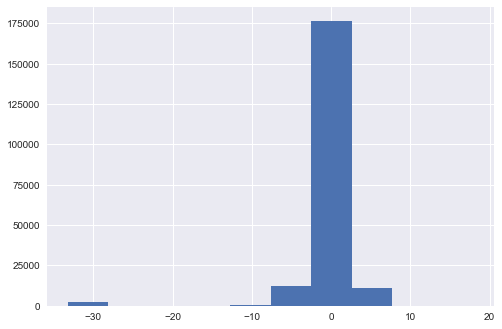

In [45]:
# distribution of target varaible
#Loyalty numerical score calculated 2 months after historical and evaluation period
df_train.target.hist()

In [16]:
# There are apparently 2207 outliers less than -30, which contribute to the majority of the RMSE
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1 #when target <-30, then tag as outlier
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [17]:
# why are these outliers?
# Check the pattern differences between the total vs outlier

In [21]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,0


In [26]:
# feature 1 ,2,3 are all categorical variable that need to change dtype
df_train['feature_1']=df_train['feature_1'].astype('category') 
df_train['feature_2']=df_train['feature_2'].astype('category') 
df_train['feature_3']=df_train['feature_3'].astype('category') 

In [32]:
df_train['first_active_date']=pd.to_datetime(df_train['first_active_month'])
df_train['first_active_month']=df_train['first_active_date'].dt.month
df_train['first_active_weekday_nm']=df_train['first_active_date'].dt.weekday_name

In [35]:
df_train['first_active_date']=df_train['first_active_date'].astype('category') 
df_train['outliers']=df_train['outliers'].astype('category') 

In [ ]:
count=1
for i in range(len(cat_v)):
    fig = plt.figure(figsize=(12,10))
    plt.subplot(len(cat_v),2,count)
    plt.bar(train_data[cat_v[i]].value_counts().index, train_data[cat_v[i]].value_counts().values)
    plt.title("train "+cat_v[i])
    
    plt.subplot(len(cat_v),2,count+1)
    plt.bar(test_data[cat_v[i]].value_counts().index, test_data[cat_v[i]].value_counts().values)
    plt.title("test "+cat_v[i])
    count+=2

## Create hist-new interacations

In [47]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label) ##？？


In [48]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_diff_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_weekend_sum,hist_weekend_mean,hist_category_1_sum,hist_category_1_mean,hist_card_id_size,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_hist_month_nunique,new_hist_purchase_amount_sum,new_hist_purchase_amount_max,new_hist_purchase_amount_min,new_hist_purchase_amount_mean,new_hist_purchase_amount_var,new_hist_installments_sum,new_hist_installments_max,new_hist_installments_min,new_hist_installments_mean,new_hist_installments_var,new_hist_purchase_date_max,new_hist_purchase_date_min,new_hist_month_lag_max,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_month_diff_mean,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_hour_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,new_hist_year_nunique,new_hist_subsector_id_nunique,new_hist_merchant_id_nunique,new_hist_merchant_category_id_nunique,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_hist_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820283,9,-165.968739,2.258395,-0.739395,-0.638341,0.045003,4,1,0,0.015385,0.015206,1.519551e+09,1.498573e+09,0,-8,-3.911538,5.748901,10.126923,247,0.950000,90,0.346154,0,0.000000,260,23,35,7,2,21,94,41,0.072502,0.346719,242,0.930769,306,2.0,-13.244202,-0.296112,-0.724368,-0.575835,0.018445,0.0,0.0,0.0,0.000000,0.000000,1.525001e+09,1.520259e+09,2.0,1.0,1.478261,0.260870,10.000000,6.0,0.260870,0.0,0.000000,23.0,8.0,7.0,7.0,1.0,10.0,23.0,14.0,-0.550160,-0.592993,54.0,2.347826,243.0,0,3,22,6,575,26,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392913,12,-210.006336,4.630299,-0.742400,-0.600018,0.148200,543,10,-1,1.551429,2.282448,1.517438e+09,1.483720e+09,0,-12,-5.031429,14.477519,11.137143,339,0.968571,132,0.377143,31,0.088571,350,24,50,7,2,24,142,57,0.074568,-0.295163,390,1.114286,330,2.0,-4.355735,-0.701858,-0.739410,-0.725956,0.000205,6.0,1.0,1.0,1.000000,0.000000,1.522393e+09,1.517505e+09,2.0,1.0,1.500000,0.300000,11.166667,0.0,0.000000,0.0,0.000000,6.0,5.0,4.0,4.0,1.0,4.0,6.0,5.0,-0.550160,-0.606486,56.0,9.333333,273.0,0,6,52,1,726,5,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.688056,10,-29.167391,-0.145847,-0.730138,-0.678311,0.007635,0,0,0,0.000000,0.000000,1.519759e+09,1.484123e+09,0,-13,-8.604651,14.768549,10.093023,41,0.953488,11,0.255814,0,0.000000,43,14,22,7,2,7,13,8,-0.087803,0.358458,412,9.581395,304,1.0,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.0,0.0,0.000000,NaN,1.524937e+09,1.524937e+09,2.0,2.0,2.000000,NaN,10.000000,1.0,1.000000,0.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.549015,-0.592993,0.0,0.000000,244.0,0,0,31,8,879,163,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142495,6,-49.491364,1.445596,-0.740897,-0.642745,0.068447,84,3,-1,1.090909,0.346890,1.519818e+09,1.506443e+09,0,-5,-2.831169,3.247437,10.077922,77,1.000000,11,0.142857,12,0.155844,77,16,20,7,2,13,50,25,-0.086166,-0.338321,154,2.000000,303,2.0,-4.6543

# Training the model

Here we will be using a technique called "stacking" to train the model. We will take a dive into stacking in week 3 and for now you can just think it as a normal training-predicting process.

In [49]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']

In [47]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()


In [50]:

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[545]	training's rmse: 3.74746	valid_1's rmse: 3.8287
fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[363]	training's rmse: 3.76618	valid_1's rmse: 3.82053
fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[427]	training's rmse: 3.75886	valid_1's rmse: 3.81873
fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[526]	training's rmse: 3.75387	valid_1's rmse: 3.81276
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 3.7705	valid_1's rmse: 3.80609


3.8173703093499456

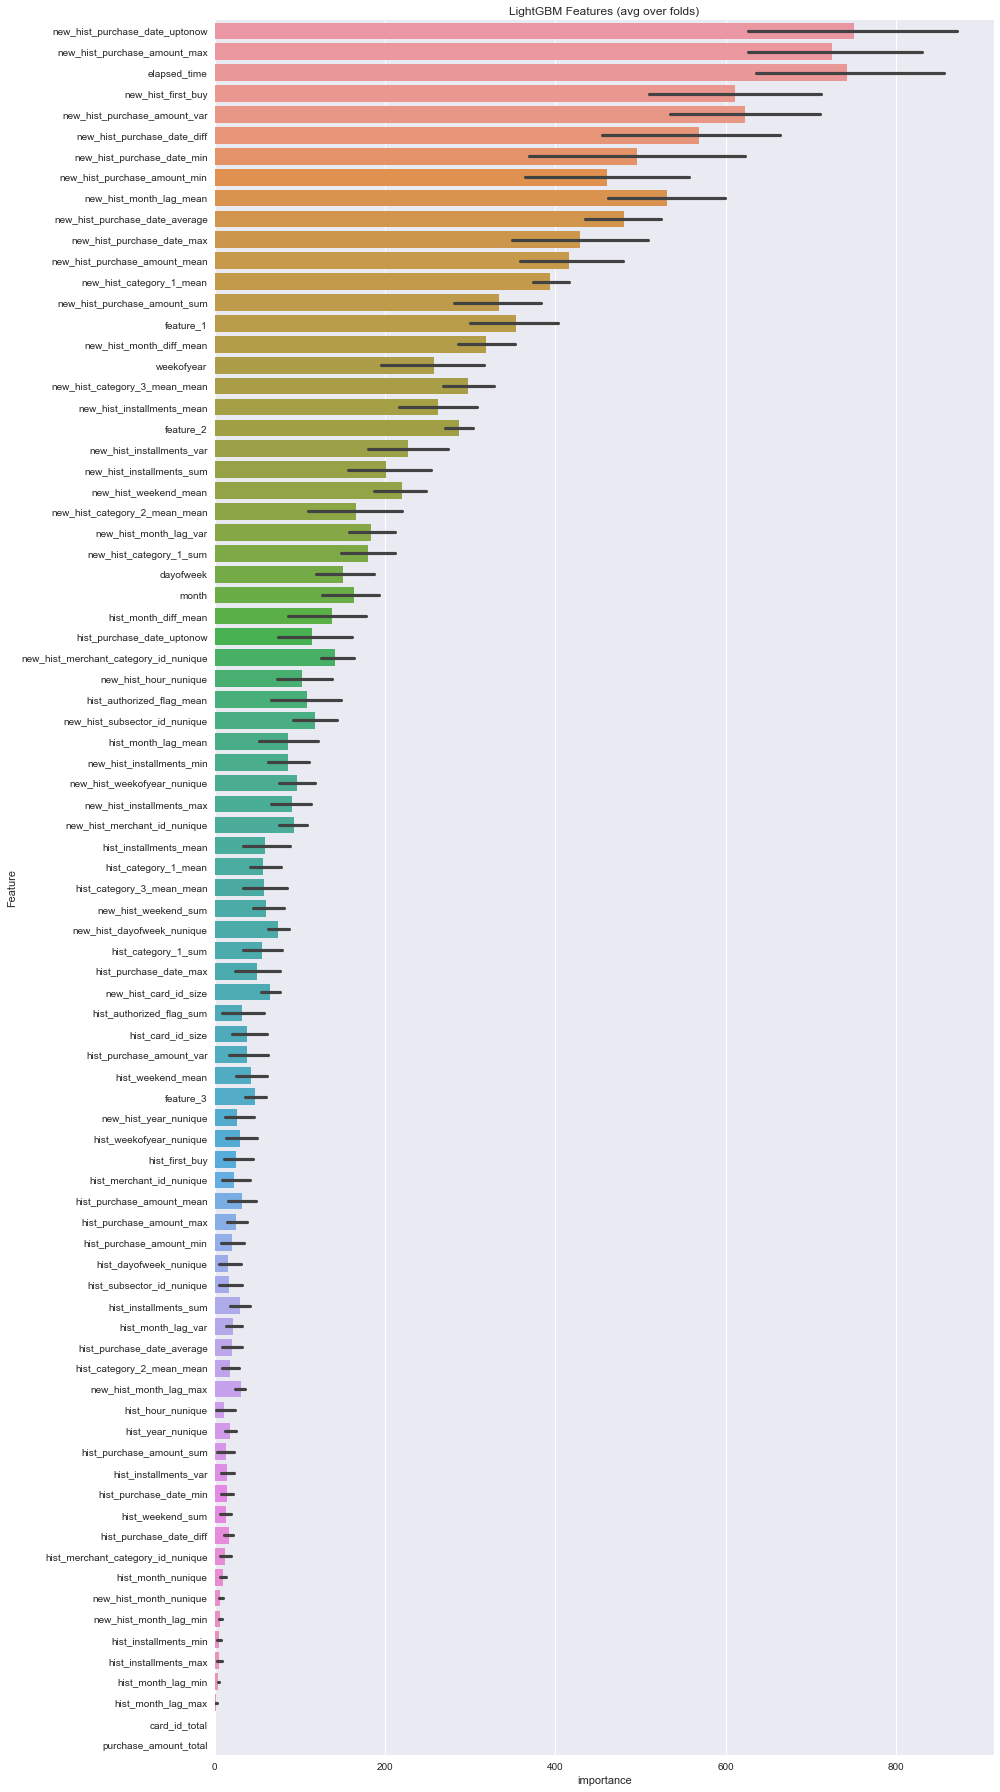

In [52]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [53]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_starter.csv", index=False)

# Additional feature engineerings

### Generating finer aggregations using pandas pivot table

Why looking at member before and after? is it because at some certain time, some merchant /shopping policy got changed?

#installment: buy products in multiple time peiords -1, 0, 1-10
#month_lag : 0,1,2,3 period is different : ? why the transaction is seperated? in historical and new transaction?
#key: how to aggregate many transactions to one to build model (at card id level)? to aviod missing information 

In [52]:
df_hist_pivot = df_hist_trans.pivot_table(index='card_id', columns='month_lag', values='merchant_id', aggfunc='count')
df_hist_pivot.columns = ['hist_tran_count_month_lag_' + str(c) for c in df_hist_pivot.columns]
hist_month_lag_count_columns = list(df_hist_pivot.columns)
df_hist_pivot = df_hist_pivot.reset_index()
df_hist_pivot.head()

,card_id,hist_tran_count_month_lag_-13,hist_tran_count_month_lag_-12,hist_tran_count_month_lag_-11,hist_tran_count_month_lag_-10,hist_tran_count_month_lag_-9,hist_tran_count_month_lag_-8,hist_tran_count_month_lag_-7,hist_tran_count_month_lag_-6,hist_tran_count_month_lag_-5,hist_tran_count_month_lag_-4,hist_tran_count_month_lag_-3,hist_tran_count_month_lag_-2,hist_tran_count_month_lag_-1,hist_tran_count_month_lag_0
0,C_ID_00007093c1,NaN,4.0,10.0,12.0,10.0,19.0,15.0,17.0,5.0,17.0,6.0,12.0,10.0,12.0
1,C_ID_0001238066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,11.0,23.0,37.0,26.0,24.0
2,C_ID_0001506ef0,2.0,5.0,8.0,NaN,1.0,3.0,2.0,2.0,2.0,3.0,7.0,18.0,7.0,6.0
3,C_ID_0001793786,NaN,NaN,NaN,NaN,2.0,6.0,16.0,30.0,4.0,37.0,29.0,34.0,38.0,20.0
4,C_ID_000183fdda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,22.0,25.0,9.0,26.0,28.0,28.0


In [53]:
df_train = df_train.merge(df_hist_pivot,on='card_id',how='left')
df_test = df_test.merge(df_hist_pivot,on='card_id',how='left')
print (df_train.shape, df_test.shape)

(201917, 101) (123623, 99)


In [54]:
del df_hist_pivot
import gc
gc.collect()

42

Let's rerun the model with newly added features:

In [58]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns

In [55]:
from sklearn.model_selection import StratifiedKFold
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 1589}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1589)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.38474	valid_1's rmse: 3.62532
Early stopping, best iteration is:
[1257]	training's rmse: 3.34523	valid_1's rmse: 3.62401
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.36658	valid_1's rmse: 3.67871
Early stopping, best iteration is:
[1649]	training's rmse: 3.27109	valid_1's rmse: 3.67733
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.38282	valid_1's rmse: 3.63286
Early stopping, best iteration is:
[1250]	training's rmse: 3.34221	valid_1's rmse: 3.6312
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.36636	valid_1's rmse: 3.6743
Early stopping, best iteration is:
[1039]	training's rmse: 3.35969	valid_1's rmse: 3.67404
fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.36514	valid_1's rmse: 3.67006
Early st

3.655254188164691

In [61]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_1.csv", index=False)

## Aggregate categorical features in transactions with NLP embedding

use merchant id as list, find users if they have shopping pattern to some merchants

In [56]:
df_hist_tran_as_sentence = df_hist_trans[['card_id','merchant_id']].astype('unicode').fillna('None')\
        .groupby('card_id')['merchant_id'].apply(list).apply(lambda x: ','.join(x)).reset_index()

In [57]:
df_hist_tran_as_sentence.head()

,card_id,merchant_id
0,C_ID_00007093c1,"M_ID_9400cf2342,M_ID_a33355a1b7,M_ID_15446e939..."
1,C_ID_0001238066,"M_ID_3f35ef9a50,M_ID_d17aabd756,M_ID_d17aabd75..."
2,C_ID_0001506ef0,"M_ID_93aa47602a,M_ID_b1fc88154d,M_ID_44a56d9dd..."
3,C_ID_0001793786,"M_ID_bff5cd4d78,M_ID_440f8472c0,M_ID_519b9d292..."
4,C_ID_000183fdda,"M_ID_00a6ca8a8a,M_ID_34d4a9cd0e,M_ID_4c2264f29..."


In [58]:
encoder = CountVectorizer(tokenizer=lambda x: x.split(','))
topic_sparse = encoder.fit_transform(df_hist_tran_as_sentence['merchant_id'].values)
decomposer = TruncatedSVD(n_components=10) #use SVD to reduce dimensions
topic_matrix = decomposer.fit_transform(topic_sparse)

df_hist_tfidf = pd.DataFrame(topic_matrix, columns=['tfidf_' + 'merchant_id' + '_' + str(i) for i in range(10)])
tfidf_hist_merchant_columns = list(df_hist_tfidf.columns)
df_hist_tfidf['card_id'] = df_hist_tran_as_sentence['card_id']

In [59]:
df_hist_tfidf.head()

,tfidf_merchant_id_0,tfidf_merchant_id_1,tfidf_merchant_id_2,tfidf_merchant_id_3,tfidf_merchant_id_4,tfidf_merchant_id_5,tfidf_merchant_id_6,tfidf_merchant_id_7,tfidf_merchant_id_8,tfidf_merchant_id_9,card_id
0,0.128548,0.559790,-0.003711,0.844632,-0.154813,2.020309,0.242176,0.299723,19.948403,-2.938564,C_ID_00007093c1
1,0.254163,0.837185,-0.011688,-0.085254,0.470054,-0.882057,3.280227,0.610943,0.046641,-0.201714,C_ID_0001238066
2,0.296615,2.036298,-0.050997,-0.339231,-0.062978,0.106880,-0.483561,-0.108600,-0.014322,0.090561,C_ID_0001506ef0
3,0.855702,5.773372,-0.145295,-0.780740,-0.155404,0.254217,-1.135730,-0.190668,0.284956,0.041125,C_ID_0001793786
4,0.724597,4.949523,-0.125805,-0.790483,-0.129785,0.190094,-0.902703,-0.219191,-0.125807,-0.025764,C_ID_000183fdda


In [60]:
df_train = df_train.merge(df_hist_tfidf,on='card_id',how='left')
df_test = df_test.merge(df_hist_tfidf,on='card_id',how='left')
print (df_train.shape, df_test.shape)

del df_hist_tfidf
gc.collect(0)

(201917, 111) (123623, 109)


35

In [61]:
df_train_columns = ['feature_1',
                    'feature_2',
                    'feature_3',
                    'hist_month_nunique',
                    'hist_hour_nunique',
                    'hist_weekofyear_nunique',
                    'hist_dayofweek_nunique',
                    'hist_year_nunique',
                    'hist_subsector_id_nunique',
                    'hist_merchant_id_nunique',
                    'hist_merchant_category_id_nunique',
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_mean',
                    'hist_purchase_amount_var',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_mean',
                    'hist_installments_var',
                    'hist_purchase_date_max',
                    'hist_purchase_date_min',
                    'hist_month_lag_max',
                    'hist_month_lag_min',
                    'hist_month_lag_mean',
                    'hist_month_lag_var',
                    'hist_month_diff_mean',
                    'hist_authorized_flag_sum',
                    'hist_authorized_flag_mean',
                    'hist_weekend_sum',
                    'hist_weekend_mean',
                    'hist_category_1_sum',
                    'hist_category_1_mean',
                    'hist_card_id_size',
                    'hist_category_2_mean_mean',
                    'hist_category_3_mean_mean',
                    'hist_purchase_date_diff',
                    'hist_purchase_date_average',
                    'hist_purchase_date_uptonow',
                    'new_hist_month_nunique',
                    'new_hist_hour_nunique',
                    'new_hist_weekofyear_nunique',
                    'new_hist_dayofweek_nunique',
                    'new_hist_year_nunique',
                    'new_hist_subsector_id_nunique',
                    'new_hist_merchant_id_nunique',
                    'new_hist_merchant_category_id_nunique',
                    'new_hist_purchase_amount_sum',
                    'new_hist_purchase_amount_max',
                    'new_hist_purchase_amount_min',
                    'new_hist_purchase_amount_mean',
                    'new_hist_purchase_amount_var',
                    'new_hist_installments_sum',
                    'new_hist_installments_max',
                    'new_hist_installments_min',
                    'new_hist_installments_mean',
                    'new_hist_installments_var',
                    'new_hist_purchase_date_max',
                    'new_hist_purchase_date_min',
                    'new_hist_month_lag_max',
                    'new_hist_month_lag_min',
                    'new_hist_month_lag_mean',
                    'new_hist_month_lag_var',
                    'new_hist_month_diff_mean',
                    'new_hist_weekend_sum',
                    'new_hist_weekend_mean',
                    'new_hist_category_1_sum',
                    'new_hist_category_1_mean',
                    'new_hist_card_id_size',
                    'new_hist_category_2_mean_mean',
                    'new_hist_category_3_mean_mean',
                    'new_hist_purchase_date_diff',
                    'new_hist_purchase_date_average',
                    'new_hist_purchase_date_uptonow',
                    'dayofweek',
                    'weekofyear',
                    'month',
                    'elapsed_time',
                    'hist_first_buy',
                    'new_hist_first_buy',
                    'card_id_total',
                    'purchase_amount_total'] + hist_month_lag_count_columns + tfidf_hist_merchant_columns

In [62]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 1902}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34203	valid_1's rmse: 3.65218
Early stopping, best iteration is:
[1114]	training's rmse: 3.32214	valid_1's rmse: 3.65153
fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.33732	valid_1's rmse: 3.6516
Early stopping, best iteration is:
[1201]	training's rmse: 3.30035	valid_1's rmse: 3.65071
fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34235	valid_1's rmse: 3.6468
Early stopping, best iteration is:
[1258]	training's rmse: 3.29621	valid_1's rmse: 3.64552
fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 3.34195	valid_1's rmse: 3.65398
[2000]	training's rmse: 3.1867	valid_1's rmse: 3.64931
Early stopping, best iteration is:
[2099]	training's rmse: 3.17286	valid_1's rmse: 3.64885
fold 4
Training until validation scores don't improve for 100 rounds.
Early sto

3.6499107972867884

In [63]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission_1228.csv", index=False)

## Food for thoughts

There are a few thoughts that might be the key to success for this competition:

1. Outliers
    *     The majority of RMSE was contributed by outliers. How can we handle or leverage it? What
    *      What could the outliers actually be?
2.  Month lag
    *     What does "month lag" mean? 
    *     Why it appears to be important?
    *     How can we leverage it?
3.  Installments
    *     What does "installments" mean? 
    *     How can we leverage it?
    *     What does installment interact with other features such as month lag, cateogrical 3 etc?
4. Purchase amount
    *     Why purchase amount can be negative?
    *     Why there are a lot of positive outliers on purchase amount?
    *     Why it's not as important as expected?
5.   New vs history transactions
    *   Why there's no overlap between history and new transactions? 
    *   What could be the relationship between history and new transactions?
   
   


# Additional readings
* [Applied Predictive Modeling - Chapter 3 Data Pre-Processing](http://appliedpredictivemodeling.com/toc/)
* [机器学习特征工程实用技巧大全](https://zhuanlan.zhihu.com/p/26444240)
* [Discover Feature Engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
* [Selecting good features – Part IV: stability selection, RFE and everything side by side](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)